In [1]:
#import all packages here 
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot
import scipy.stats
import statsmodels.stats.power as smp
import statsmodels.api as sm
import statsmodels.stats.multicomp as mc


In [2]:

URL = "https://raw.githubusercontent.com/shionguha/inf2178-expdesignfordatascience-w23/main/project%20dataset/Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv"
df = pd.read_csv(URL)
df

,Arrest_Year,Arrest_Month,EventID,ArrestID,PersonID,Perceived_Race,Sex,Age_group__at_arrest_,Youth_at_arrest__under_18_years,ArrestLocDiv,...,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative,SearchReason_CauseInjury,SearchReason_AssistEscape,SearchReason_PossessWeapons,SearchReason_PossessEvidence,ItemsFound,ObjectId
0,2020,July-Sept,1005907,6017884.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,1
1,2020,July-Sept,1014562,6056669.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,2
2,2020,Oct-Dec,1029922,6057065.0,326622,Unknown or Legacy,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,3
3,2021,Jan-Mar,1052190,6029059.0,327535,Black,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4
4,2021,Jan-Mar,1015512,6040372.0,327535,South Asian,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65271,2021,Oct-Dec,1055609,6044336.0,316123,Indigenous,F,Aged 25 to 34 years,Not a youth,XX,...,1,0,0,0,NaN,NaN,NaN,NaN,NaN,65272
65272,2021,Oct-Dec,1032758,6031692.0,307736,South Asian,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,65273
65273,2021,Oct-Dec,1021067,6064396.0,324057,White,F,Aged 45 to 54 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,65274
65274,2021,Oct-Dec,1008998,6008662.0,331870,Unknown or Legacy,M,Aged 17 years and under,Youth (aged 17 years and under),XX,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,65275


#Cleaning Data

In [3]:
#these are instances outside of Toronto City Limits
df = df[df['ArrestLocDiv'] != 'XX']
#we are viewing biological sex as m and f. U is not defined and there are only 4 values. We understand that gender is a construct, however in this context
#it is not applicable as TPS place booked persons based on their gentialia i.e. biological sex
df = df[df['Sex'] != 'U']

In [4]:
df.isnull().sum()

Arrest_Year                            0
Arrest_Month                           0
EventID                                0
ArrestID                               0
PersonID                               0
Perceived_Race                         1
Sex                                    0
Age_group__at_arrest_                  8
Youth_at_arrest__under_18_years        0
ArrestLocDiv                           0
StripSearch                            0
Booked                                 0
Occurrence_Category                   25
Actions_at_arrest___Concealed_i        0
Actions_at_arrest___Combative__        0
Actions_at_arrest___Resisted__d        0
Actions_at_arrest___Mental_inst        0
Actions_at_arrest___Assaulted_o        0
Actions_at_arrest___Cooperative        0
SearchReason_CauseInjury           29332
SearchReason_AssistEscape          29332
SearchReason_PossessWeapons        29332
SearchReason_PossessEvidence       29332
ItemsFound                         29332
ObjectId        

In [5]:
df.dropna(subset=['Perceived_Race'], inplace=True)

In [6]:
df.dropna(subset=['Age_group__at_arrest_'], inplace=True)
df['Age_group__at_arrest_'].unique()

array(['Aged 35 to 44 years', 'Aged 25 to 34 years',
       'Aged 45 to 54 years', 'Aged 18 to 24 years',
       'Aged 55 to 64 years', 'Aged 65 and older',
       'Aged 65 years and older', 'Aged 17 years and younger',
       'Aged 17 years and under'], dtype=object)

In [7]:
#converting age groups into continous variable 
age_group_mapping = {
    'Aged 17 years and younger':(17),
    'Aged 17 years and under': (17),
    'Aged 18 to 24 years': (21.5),
    'Aged 25 to 34 years': (32.8),
    'Aged 35 to 44 years': (43.9),
    'Aged 45 to 54 years': (49.7),
    'Aged 55 to 64 years': (59.5),
    'Aged 65 and older': (65),
    'Aged 65 years and older':(65)
}

df['Age_group__at_arrest_'] = df['Age_group__at_arrest_'].replace(age_group_mapping)


In [8]:
df['Age_group__at_arrest_'].unique()

array([43.9, 32.8, 49.7, 21.5, 59.5, 65. , 17. ])

In [9]:
quarter_map = {
    "Jan-Mar": 1,
    "Apr-Jun": 2,
    "Apr-June":2,
    "July-Sept": 3,
    "Oct-Dec": 4
}

df['Arrest_Month'] = df['Arrest_Month'].replace(quarter_map) 
df['Arrest_Month'].unique()


array([3, 4, 2, 1])

#EDA

<ipython-input-10-ba02f60adc35>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


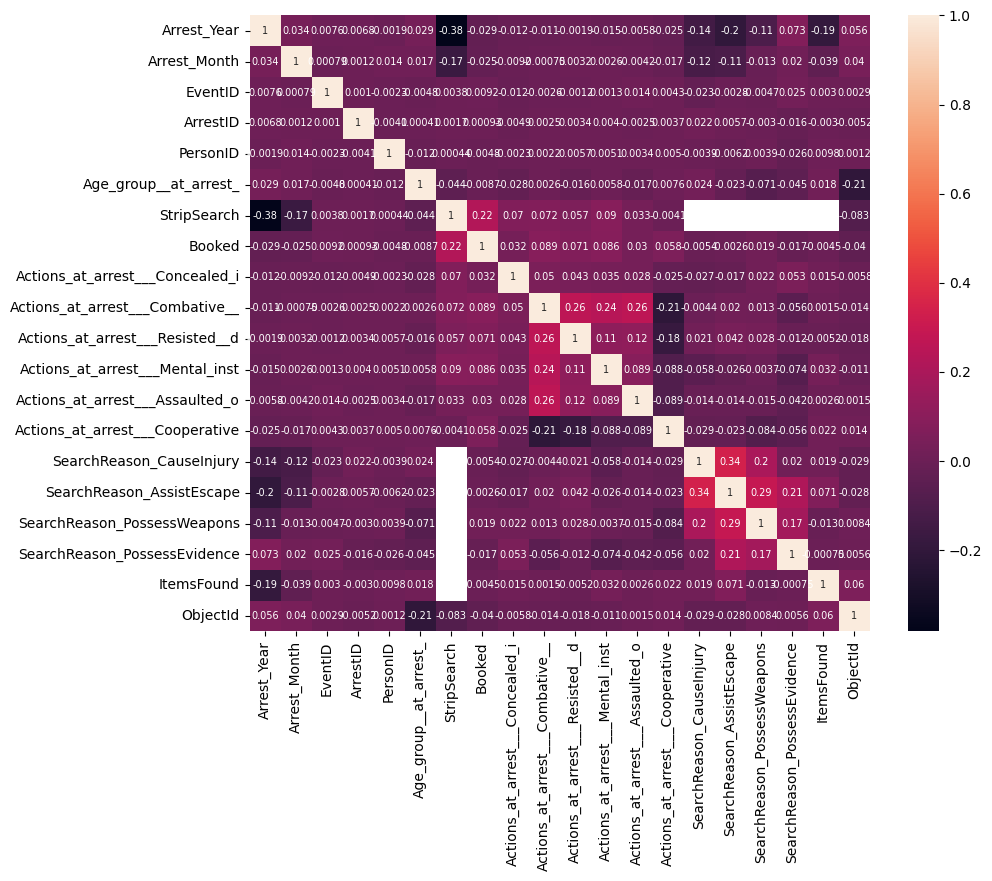

In [10]:
corr_matrix = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 7})
plt.show()

Correlation between Mental Health Crisis and:

1)Actions_at_arrest___Combative__  
2) Actions_at_arrest___Resisted__d



In [11]:
corr_matrix = df.corr()

# Get the top 5 positive and negative correlations
corr_matrix = corr_matrix.mask(np.triu(np.ones(corr_matrix.shape)).astype(np.bool))
top_positive = corr_matrix.unstack().sort_values(ascending=False)[:5]
top_negative = corr_matrix.unstack().sort_values()[:5]
print("Top 5 positive correlations:")
print(top_positive)
print("\nTop 5 negative correlations:")
print(top_negative)

Top 5 positive correlations:
SearchReason_CauseInjury         SearchReason_AssistEscape          0.338460
SearchReason_AssistEscape        SearchReason_PossessWeapons        0.290227
Actions_at_arrest___Combative__  Actions_at_arrest___Assaulted_o    0.260223
                                 Actions_at_arrest___Resisted__d    0.260189
                                 Actions_at_arrest___Mental_inst    0.241561
dtype: float64

Top 5 negative correlations:
Arrest_Year                      StripSearch                       -0.382512
Actions_at_arrest___Combative__  Actions_at_arrest___Cooperative   -0.214554
Age_group__at_arrest_            ObjectId                          -0.209104
Arrest_Year                      SearchReason_AssistEscape         -0.199185
                                 ItemsFound                        -0.192501
dtype: float64


<ipython-input-11-4a3e153fe273>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()
<ipython-input-11-4a3e153fe273>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  corr_matrix = corr_matrix.mask(np.triu(np.ones(corr_matrix.shape)).astype(np.bool))


In [12]:
counts = df['Actions_at_arrest___Mental_inst'].value_counts()
print(counts)

0    34084
1     1533
Name: Actions_at_arrest___Mental_inst, dtype: int64


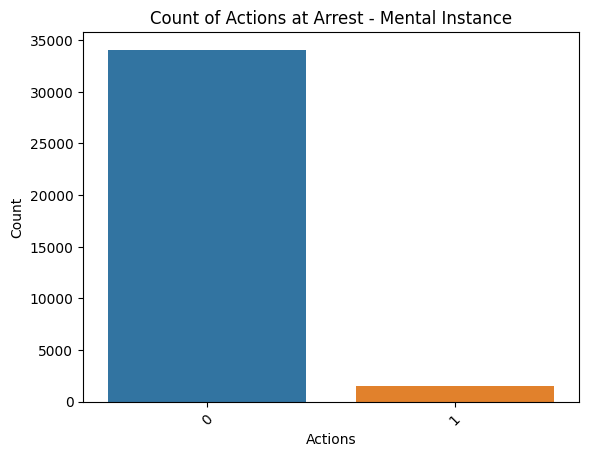

In [13]:
sns.barplot(x=counts.index, y=counts)
plt.title('Count of Actions at Arrest - Mental Instance')
plt.xlabel('Actions')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [14]:
df.columns

Index(['Arrest_Year', 'Arrest_Month', 'EventID', 'ArrestID', 'PersonID',
       'Perceived_Race', 'Sex', 'Age_group__at_arrest_',
       'Youth_at_arrest__under_18_years', 'ArrestLocDiv', 'StripSearch',
       'Booked', 'Occurrence_Category', 'Actions_at_arrest___Concealed_i',
       'Actions_at_arrest___Combative__', 'Actions_at_arrest___Resisted__d',
       'Actions_at_arrest___Mental_inst', 'Actions_at_arrest___Assaulted_o',
       'Actions_at_arrest___Cooperative', 'SearchReason_CauseInjury',
       'SearchReason_AssistEscape', 'SearchReason_PossessWeapons',
       'SearchReason_PossessEvidence', 'ItemsFound', 'ObjectId'],
      dtype='object')

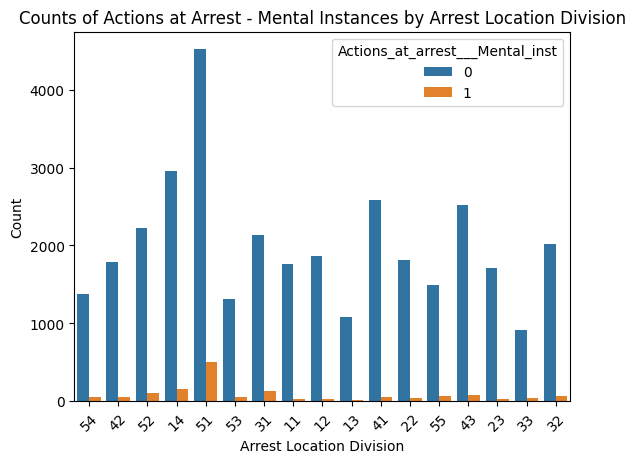

In [15]:
df_mental_inst = df[df['Actions_at_arrest___Mental_inst'].notnull()]
sns.countplot(x='ArrestLocDiv', hue='Actions_at_arrest___Mental_inst', data=df_mental_inst)
plt.title('Counts of Actions at Arrest - Mental Instances by Arrest Location Division')
plt.xlabel('Arrest Location Division')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [16]:
counts = df['Actions_at_arrest___Combative__'].value_counts()
print(counts)

0    33559
1     2058
Name: Actions_at_arrest___Combative__, dtype: int64


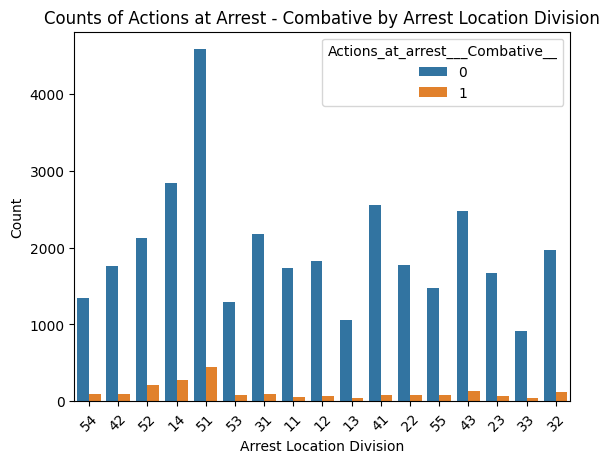

In [17]:
sns.countplot(x='ArrestLocDiv', hue='Actions_at_arrest___Combative__', data=df)
plt.title('Counts of Actions at Arrest - Combative by Arrest Location Division')
plt.xlabel('Arrest Location Division')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

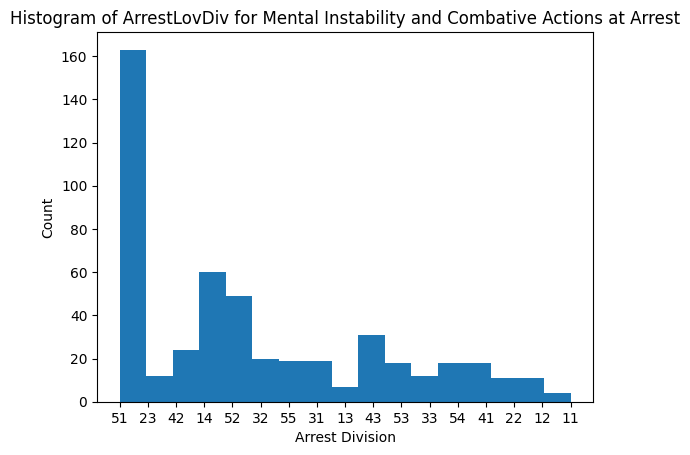

In [18]:
filtered_df = df[(df["Actions_at_arrest___Mental_inst"] == 1) & (df["Actions_at_arrest___Combative__"] == 1)]
X = filtered_df["ArrestLocDiv"]

# Create a histogram of the filtered data
plt.hist(X, bins=17)
plt.xlabel("Arrest Division")
plt.ylabel("Count")
plt.title("Histogram of ArrestLovDiv for Mental Instability and Combative Actions at Arrest")
plt.show()

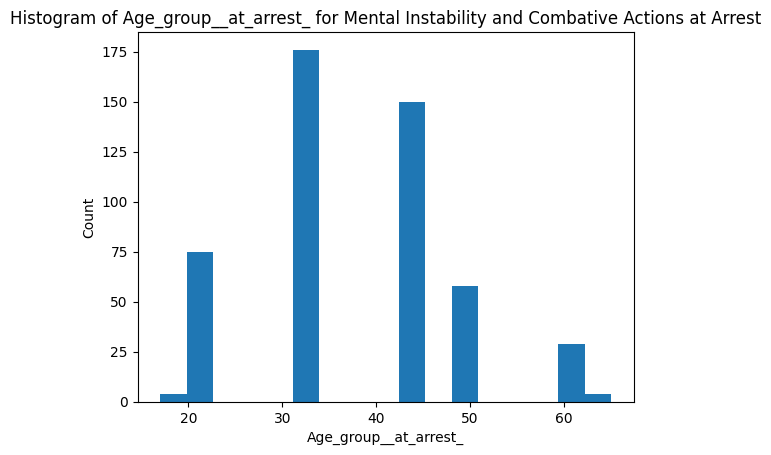

In [19]:
filtered_df = df[(df["Actions_at_arrest___Mental_inst"] == 1) & (df["Actions_at_arrest___Combative__"] == 1)]
X = filtered_df["Age_group__at_arrest_"]

# Create a histogram of the filtered data
plt.hist(X, bins=17)
plt.xlabel("Age_group__at_arrest_")
plt.ylabel("Count")
plt.title("Histogram of Age_group__at_arrest_ for Mental Instability and Combative Actions at Arrest")
plt.show()

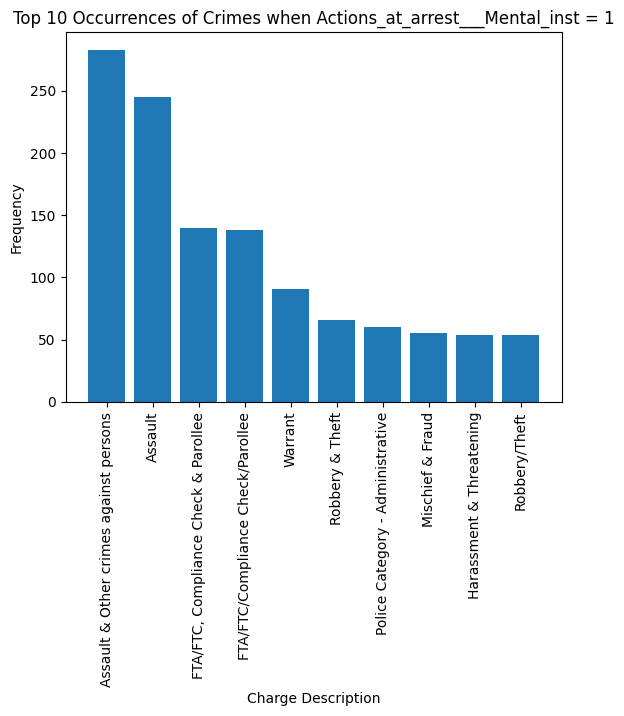

In [20]:
# Filter the dataframe to only include rows where Actions_at_arrest___Mental_inst is 1
mental_inst_df = df[df['Actions_at_arrest___Mental_inst'] == 1]

# Get the top 10 crimes by frequency
top_crimes = mental_inst_df['Occurrence_Category'].value_counts().nlargest(10)
plt.bar(top_crimes.index, top_crimes.values)
plt.xticks(rotation=90)
plt.xlabel('Charge Description')
plt.ylabel('Frequency')
plt.title('Top 10 Occurrences of Crimes when Actions_at_arrest___Mental_inst = 1')
plt.show()

In [21]:
df.columns

Index(['Arrest_Year', 'Arrest_Month', 'EventID', 'ArrestID', 'PersonID',
       'Perceived_Race', 'Sex', 'Age_group__at_arrest_',
       'Youth_at_arrest__under_18_years', 'ArrestLocDiv', 'StripSearch',
       'Booked', 'Occurrence_Category', 'Actions_at_arrest___Concealed_i',
       'Actions_at_arrest___Combative__', 'Actions_at_arrest___Resisted__d',
       'Actions_at_arrest___Mental_inst', 'Actions_at_arrest___Assaulted_o',
       'Actions_at_arrest___Cooperative', 'SearchReason_CauseInjury',
       'SearchReason_AssistEscape', 'SearchReason_PossessWeapons',
       'SearchReason_PossessEvidence', 'ItemsFound', 'ObjectId'],
      dtype='object')

# Power Analysis

### For ANOVA

In [22]:
import scipy.stats
import statsmodels.stats.power as smp
import matplotlib.pyplot as plt

power_analysis = smp.TTestIndPower()
sample_size = power_analysis.solve_power(effect_size=0.5, power=0.8, alpha=0.05)

print('Required sample size: {0:.2f}'.format(sample_size))

Required sample size: 63.77


/usr/local/lib/python3.9/dist-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/usr/local/lib/python3.9/dist-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: invalid value encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


<ipython-input-23-a3fccbfddcff>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


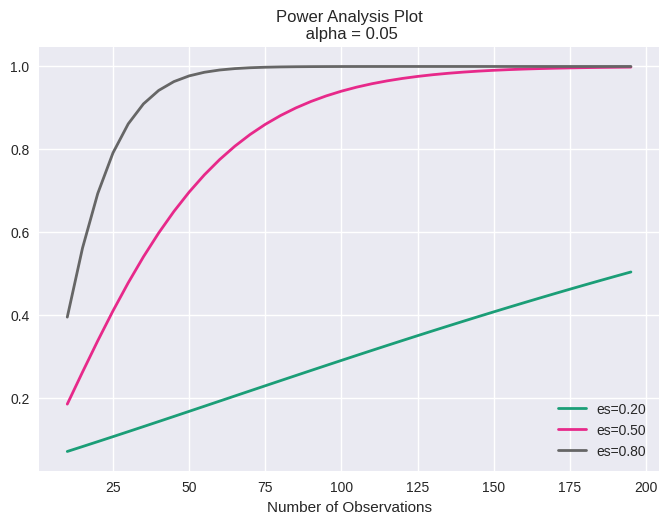

In [23]:
#+
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(10, 200, 5))

plt.style.use('seaborn')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig = power_analysis.plot_power(dep_var='nobs', nobs=sample_sizes,  
    effect_size=effect_sizes, alpha=0.05, ax=ax, 
    title='Power Analysis Plot\n alpha = 0.05')

# ANOVA

In [24]:
# refresh data / start from scratch
URL = "https://raw.githubusercontent.com/shionguha/inf2178-expdesignfordatascience-w23/main/project%20dataset/Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv"
_df = pd.read_csv(URL)
cdf = _df[~_df.Occurrence_Category.isnull() & _df.Sex.isin(['M', 'F'])]
cdf['date'] = cdf.Arrest_Year.apply(str) + '-' + cdf.Arrest_Month.replace({'Jan-Mar': 'Q1', 'Apr-June': 'Q2', 'July-Sept': 'Q3', 'Oct-Dec': 'Q4'})
age_group_mapping = {
    'Aged 17 years and younger':17,
    'Aged 17 years and under': 17,
    'Aged 18 to 24 years': 21.5,
    'Aged 25 to 34 years': 32.8,
    'Aged 35 to 44 years': 43.9,
    'Aged 45 to 54 years': 49.7,
    'Aged 55 to 64 years': 59.5,
    'Aged 65 and older': 65,
    'Aged 65 years and older':65
}

cdf['age'] = cdf['Age_group__at_arrest_'].replace(age_group_mapping)
cdf = cdf[['date', 'age'] + [c for c in cdf.columns if c not in ['date','age']]]
cdf = cdf[cdf.ArrestLocDiv != 'XX']
cdfm = cdf[cdf.Actions_at_arrest___Mental_inst == 1]
cdf

<ipython-input-24-33dd1bd88085>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['date'] = cdf.Arrest_Year.apply(str) + '-' + cdf.Arrest_Month.replace({'Jan-Mar': 'Q1', 'Apr-June': 'Q2', 'July-Sept': 'Q3', 'Oct-Dec': 'Q4'})
<ipython-input-24-33dd1bd88085>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['age'] = cdf['Age_group__at_arrest_'].replace(age_group_mapping)


,date,age,Arrest_Year,Arrest_Month,EventID,ArrestID,PersonID,Perceived_Race,Sex,Age_group__at_arrest_,...,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative,SearchReason_CauseInjury,SearchReason_AssistEscape,SearchReason_PossessWeapons,SearchReason_PossessEvidence,ItemsFound,ObjectId
0,2020-Q3,43.9,2020,July-Sept,1005907,6017884.0,326622,White,M,Aged 35 to 44 years,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,1
1,2020-Q3,43.9,2020,July-Sept,1014562,6056669.0,326622,White,M,Aged 35 to 44 years,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,2
2,2020-Q4,43.9,2020,Oct-Dec,1029922,6057065.0,326622,Unknown or Legacy,M,Aged 35 to 44 years,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,3
5,2021-Q2,32.8,2021,Apr-June,1019145,6060688.0,327535,South Asian,M,Aged 25 to 34 years,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,6
6,2021-Q1,32.8,2021,Jan-Mar,1035445,6053833.0,330778,Black,M,Aged 25 to 34 years,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65262,2021-Q4,49.7,2021,Oct-Dec,1015921,6033239.0,327713,Black,M,Aged 45 to 54 years,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,65263
65263,2021-Q4,32.8,2021,Oct-Dec,1051353,6005135.0,330232,White,F,Aged 25 to 34 years,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,65264
65265,2021-Q4,43.9,2021,Oct-Dec,1056395,6010781.0,328862,Latino,M,Aged 35 to 44 years,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,65266
65268,2021-Q4,32.8,2021,Oct-Dec,1028795,6018445.0,328838,Black,M,Aged 25 to 34 years,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,65269


In [25]:
import plotly.graph_objects as go

fig = go.Figure()

divisions = sorted(cdf.ArrestLocDiv.unique())
for div in divisions:
  y = (cdfm[cdfm.ArrestLocDiv == div].groupby('date').ObjectId.nunique() / 
       cdf[cdf.ArrestLocDiv == div].groupby('date').ObjectId.nunique()).to_list()
  fig.add_trace(go.Box(y=y, name=div))

fig.update_layout(
    yaxis_title='% of MH Crisis Arrests per Quarter',
    xaxis_title='Police Division'
)
fig.show()

In [26]:
from scipy.stats import f_oneway
import math

# prepare data
samples = []
divisions = sorted(cdf.ArrestLocDiv.unique())
for div in divisions:
  samples.append(
      list(map(lambda x: 0 if math.isnan(x) else x, (cdfm[cdfm.ArrestLocDiv == div].groupby('date').ObjectId.nunique() / cdf[cdf.ArrestLocDiv == div].groupby('date').ObjectId.nunique()).to_list()))
       )

# One-way ANOVA
statistic, pvalue = f_oneway(*samples)

print(f'One-way ANOVA: s = {statistic}, p = {pvalue}')

One-way ANOVA: s = 13.321658017534498, p = 1.179034593060819e-19


In [27]:
rows = []
for sample, division in zip(samples, divisions):
  for s in sample:
    rows.append([s, division])
  
tukey_df = pd.DataFrame(columns=['MH crisis arrests', 'division'], data=rows)
tukey_df

,MH crisis arrests,division
0,0.018450,11
1,0.000000,11
2,0.000000,11
3,0.019048,11
4,0.012605,11
...,...,...
131,0.042424,55
132,0.028571,55
133,0.022099,55
134,0.040609,55


In [28]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=tukey_df['MH crisis arrests'],
                          groups=tukey_df['division'],
                          alpha=0.05)

#display results
# print(tukey)
dir(tukey)
print(tukey)

# ====================================================
# group1 group2 meandiff p-adj   lower   upper  reject
#     11     51   0.0878    0.0   0.059  0.1165   True
#     12     51   0.0824    0.0  0.0537  0.1111   True
#     13     51   0.0815    0.0  0.0528  0.1103   True
#     14     51   0.0494    0.0  0.0206  0.0781   True
#     22     51   0.0786    0.0  0.0499  0.1073   True
#     23     51   0.0856    0.0  0.0569  0.1144   True
#     31     51   0.0444    0.0  0.0157  0.0731   True
#     32     51   0.0674    0.0  0.0387  0.0961   True
#     33     51    0.063    0.0  0.0343  0.0917   True
#     41     51   0.0783    0.0  0.0496   0.107   True
#     42     51   0.0673    0.0  0.0386  0.0961   True
#     43     51   0.0687    0.0    0.04  0.0974   True
#     51     52  -0.0542    0.0 -0.0829 -0.0254   True
#     51     53  -0.0594    0.0 -0.0881 -0.0307   True
#     51     54  -0.0578    0.0 -0.0865  -0.029   True
#     51     55  -0.0574    0.0 -0.0861 -0.0287   True


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    11     12   0.0053    1.0 -0.0234  0.0341  False
    11     13   0.0062    1.0 -0.0225  0.0349  False
    11     14   0.0384 0.0008  0.0097  0.0671   True
    11     22   0.0092 0.9994 -0.0195  0.0379  False
    11     23   0.0021    1.0 -0.0266  0.0308  False
    11     31   0.0434 0.0001  0.0146  0.0721   True
    11     32   0.0204 0.5025 -0.0084  0.0491  False
    11     33   0.0248 0.1806  -0.004  0.0535  False
    11     41   0.0095 0.9991 -0.0192  0.0382  False
    11     42   0.0204  0.498 -0.0083  0.0491  False
    11     43    0.019  0.623 -0.0097  0.0478  False
    11     51   0.0878    0.0   0.059  0.1165   True
    11     52   0.0336 0.0071  0.0049  0.0623   True
    11     53   0.0283 0.0576 -0.0004   0.057  False
    11     54     0.03  0.031  0.0013  0.0587   True
    11     55   0.0304  0.027  0.0016  0.0591 

#ANCOVA

In [29]:
URL = "https://raw.githubusercontent.com/shionguha/inf2178-expdesignfordatascience-w23/main/project%20dataset/Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv"
_df = pd.read_csv(URL)

cdf = _df[~_df.Occurrence_Category.isnull() & _df.Sex.isin(['M', 'F'])]
cdf['date'] = cdf.Arrest_Year.apply(str) + '-' + cdf.Arrest_Month.replace({'Jan-Mar': 'Q1', 'Apr-June': 'Q2', 'July-Sept': 'Q3', 'Oct-Dec': 'Q4'})
age_group_mapping = {
    'Aged 17 years and younger':17,
    'Aged 17 years and under': 17,
    'Aged 18 to 24 years': 21.5,
    'Aged 25 to 34 years': 32.8,
    'Aged 35 to 44 years': 43.9,
    'Aged 45 to 54 years': 49.7,
    'Aged 55 to 64 years': 59.5,
    'Aged 65 and older': 65,
    'Aged 65 years and older':65
}

cdf['age'] = cdf['Age_group__at_arrest_'].replace(age_group_mapping)
cdf = cdf[['date', 'age'] + [c for c in cdf.columns if c not in ['date','age']]]
cdf = cdf[cdf.ArrestLocDiv != 'XX']
cdfm = cdf[cdf.Actions_at_arrest___Mental_inst == 1]
cdf

<ipython-input-29-daf8b3490583>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-29-daf8b3490583>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,age,Arrest_Year,Arrest_Month,EventID,ArrestID,PersonID,Perceived_Race,Sex,Age_group__at_arrest_,...,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative,SearchReason_CauseInjury,SearchReason_AssistEscape,SearchReason_PossessWeapons,SearchReason_PossessEvidence,ItemsFound,ObjectId
0,2020-Q3,43.9,2020,July-Sept,1005907,6017884.0,326622,White,M,Aged 35 to 44 years,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,1
1,2020-Q3,43.9,2020,July-Sept,1014562,6056669.0,326622,White,M,Aged 35 to 44 years,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,2
2,2020-Q4,43.9,2020,Oct-Dec,1029922,6057065.0,326622,Unknown or Legacy,M,Aged 35 to 44 years,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,3
5,2021-Q2,32.8,2021,Apr-June,1019145,6060688.0,327535,South Asian,M,Aged 25 to 34 years,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,6
6,2021-Q1,32.8,2021,Jan-Mar,1035445,6053833.0,330778,Black,M,Aged 25 to 34 years,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65262,2021-Q4,49.7,2021,Oct-Dec,1015921,6033239.0,327713,Black,M,Aged 45 to 54 years,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,65263
65263,2021-Q4,32.8,2021,Oct-Dec,1051353,6005135.0,330232,White,F,Aged 25 to 34 years,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,65264
65265,2021-Q4,43.9,2021,Oct-Dec,1056395,6010781.0,328862,Latino,M,Aged 35 to 44 years,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,65266
65268,2021-Q4,32.8,2021,Oct-Dec,1028795,6018445.0,328838,Black,M,Aged 25 to 34 years,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,65269


In [30]:
# df = pd.DataFrame({'dependent_variable' : [8, 7, 9, 11, 10, 12, 14, 13, 15, 16],
#    'group' : ["A", "A", "A", "B", "B", "B", "C", "C", "C", "C"],
#     'covariate' : [20, 30, 40, 30, 40, 50, 40, 50, 60, 70]})

# # Perform the ANCOVA
# model = ols('dependent_variable ~ group + covariate', data=df).fit()

sdf = cdf.groupby('date').age.mean()
sdf = pd.DataFrame(sdf)
sdf

samples = []
divisions = sorted(cdf.ArrestLocDiv.unique())
for div in divisions:
  samples.append(
      (
          list(map(lambda x: 0 if math.isnan(x) else x, (cdfm[cdfm.ArrestLocDiv == div].groupby('date').ObjectId.nunique() / cdf[cdf.ArrestLocDiv == div].groupby('date').ObjectId.nunique()).to_list())),
          cdf[cdf.ArrestLocDiv == div].groupby('date').age.mean().to_list()
      )
  )
  
rows = []
for sample, division in zip(samples, divisions):
  for mh, age in zip(sample[0], sample[1]):
    rows.append([mh, division, age])
  
sdf = pd.DataFrame(columns=['MH_crisis_arrests', 'division', 'person_age'], data=rows)
sdf[sdf.division == '51']

,MH_crisis_arrests,division,person_age
96,0.047059,51,36.888971
97,0.098182,51,37.623636
98,0.127298,51,38.618246
99,0.101399,51,38.680594
100,0.115142,51,39.219401
101,0.097720,51,39.011889
102,0.098214,51,38.929911
103,0.119529,51,38.327104


In [31]:
from statsmodels.formula.api import ols

model = ols('MH_crisis_arrests ~ division + person_age', data=sdf).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      MH_crisis_arrests   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     12.48
Date:                Fri, 14 Apr 2023   Prob (F-statistic):           3.89e-19
Time:                        18:48:07   Log-Likelihood:                 376.53
No. Observations:                 136   AIC:                            -717.1
Df Residuals:                     118   BIC:                            -664.6
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0163      0.057     -0.

# Logistic Regression

In [32]:
URL = "https://raw.githubusercontent.com/shionguha/inf2178-expdesignfordatascience-w23/main/project%20dataset/Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv"
_df = pd.read_csv(URL)

cdf = _df[~_df.Occurrence_Category.isnull() & _df.Sex.isin(['M', 'F'])]
cdf['date'] = cdf.Arrest_Year.apply(str) + '-' + cdf.Arrest_Month.replace({'Jan-Mar': 'Q1', 'Apr-June': 'Q2', 'July-Sept': 'Q3', 'Oct-Dec': 'Q4'})
age_group_mapping = {
    'Aged 17 years and younger':17,
    'Aged 17 years and under': 17,
    'Aged 18 to 24 years': 21.5,
    'Aged 25 to 34 years': 32.8,
    'Aged 35 to 44 years': 43.9,
    'Aged 45 to 54 years': 49.7,
    'Aged 55 to 64 years': 59.5,
    'Aged 65 and older': 65,
    'Aged 65 years and older':65
}

cdf['age'] = cdf['Age_group__at_arrest_'].replace(age_group_mapping)
cdf = cdf[['date', 'age'] + [c for c in cdf.columns if c not in ['date','age']]]
cdf = cdf[cdf.ArrestLocDiv != 'XX']
cdfm = cdf[cdf.Actions_at_arrest___Mental_inst == 1]
cdf

<ipython-input-32-daf8b3490583>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-32-daf8b3490583>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,age,Arrest_Year,Arrest_Month,EventID,ArrestID,PersonID,Perceived_Race,Sex,Age_group__at_arrest_,...,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative,SearchReason_CauseInjury,SearchReason_AssistEscape,SearchReason_PossessWeapons,SearchReason_PossessEvidence,ItemsFound,ObjectId
0,2020-Q3,43.9,2020,July-Sept,1005907,6017884.0,326622,White,M,Aged 35 to 44 years,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,1
1,2020-Q3,43.9,2020,July-Sept,1014562,6056669.0,326622,White,M,Aged 35 to 44 years,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,2
2,2020-Q4,43.9,2020,Oct-Dec,1029922,6057065.0,326622,Unknown or Legacy,M,Aged 35 to 44 years,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,3
5,2021-Q2,32.8,2021,Apr-June,1019145,6060688.0,327535,South Asian,M,Aged 25 to 34 years,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,6
6,2021-Q1,32.8,2021,Jan-Mar,1035445,6053833.0,330778,Black,M,Aged 25 to 34 years,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65262,2021-Q4,49.7,2021,Oct-Dec,1015921,6033239.0,327713,Black,M,Aged 45 to 54 years,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,65263
65263,2021-Q4,32.8,2021,Oct-Dec,1051353,6005135.0,330232,White,F,Aged 25 to 34 years,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,65264
65265,2021-Q4,43.9,2021,Oct-Dec,1056395,6010781.0,328862,Latino,M,Aged 35 to 44 years,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,65266
65268,2021-Q4,32.8,2021,Oct-Dec,1028795,6018445.0,328838,Black,M,Aged 25 to 34 years,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,65269


### whether demographic predictors, specifically ethnicity, influence the likelihood of an individual being booked and then categorized as a MH crisis

In [33]:
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

target = cdf['Actions_at_arrest___Mental_inst'].reset_index(drop=True)
ethnicity = pd.get_dummies(cdf['Perceived_Race']).reset_index(drop=True)
age = cdf['age'].reset_index(drop=True)
gender = pd.get_dummies(cdf['Sex']).reset_index(drop=True)
crime_type = pd.get_dummies(cdf['Occurrence_Category']).reset_index(drop=True)
combative_person = pd.get_dummies(cdf['Actions_at_arrest___Combative__'], prefix="Combative").reset_index(drop=True)

data = pd.concat([target, ethnicity, age, gender, crime_type, combative_person], axis=1)
data = data.loc[~data['age'].isna(), :]
y = data['Actions_at_arrest___Mental_inst']
x = data.drop(['Actions_at_arrest___Mental_inst'], axis=1)

# Use SMOTE to oversample the minority dataN
oversample = SMOTE(random_state=2)
x_resampled, y_resampled = oversample.fit_resample(ethnicity, target)

# x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)
logit_model = sm.Logit(y_resampled, x_resampled)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.687753
         Iterations 4
                                  Logit Regression Results                                 
Dep. Variable:     Actions_at_arrest___Mental_inst   No. Observations:                68134
Model:                                       Logit   Df Residuals:                    68126
Method:                                        MLE   Df Model:                            7
Date:                             Fri, 14 Apr 2023   Pseudo R-squ.:                0.007783
Time:                                     18:48:11   Log-Likelihood:                -46859.
converged:                                    True   LL-Null:                       -47227.
Covariance Type:                         nonrobust   LLR p-value:                1.865e-154
                           coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

##Odds Results for Perceived Race ~ MH Crisis

In [34]:
np.exp(result.params)

Black                   1.150352
East/Southeast Asian    0.737500
Indigenous              1.261134
Latino                  0.663909
Middle-Eastern          0.989254
South Asian             0.726482
Unknown or Legacy       0.571278
White                   1.069153
dtype: float64

In [35]:
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ["Lower CI", "Upper CI", "OR"]
np.exp(conf)

,Lower CI,Upper CI,OR
Black,1.119174,1.182399,1.150352
East/Southeast Asian,0.692081,0.785900,0.737500
Indigenous,1.160113,1.370951,1.261134
Latino,0.600862,0.733572,0.663909
Middle-Eastern,0.924304,1.058767,0.989254
South Asian,0.677057,0.779514,0.726482
Unknown or Legacy,0.537521,0.607156,0.571278
White,1.044795,1.094078,1.069153


In [36]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Logit Regression Results                                 
===========================================================================================
Dep. Variable:     Actions_at_arrest___Mental_inst   No. Observations:                68134
Model:                                       Logit   Df Residuals:                    68126
Method:                                        MLE   Df Model:                            7
Date:                             Fri, 14 Apr 2023   Pseudo R-squ.:                0.007783
Time:                                     18:48:11   Log-Likelihood:                -46859.
converged:                                    True   LL-Null:                       -47227.
Covariance Type:                         nonrobust   LLR p-value:                1.865e-154
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Black                    0.1401      0.014      9.991      0.000       0.113       0.168
East/Southeast Asian    -0.3045      0.032     -9.389      0.000      -0.368      -0.241
Indigenous               0.2320      0.043      5.446      0.000       0.149       0.316
Latino                  -0.4096      0.051     -8.046      0.000      -0.509      -0.310
Middle-Eastern          -0.0108      0.035     -0.312      0.755      -0.079       0.057
South Asian             -0.3195      0.036     -8.889      0.000      -0.390      -0.249
Unknown or Legacy       -0.5599      0.031    -18.016      0.000      -0.621      -0.499
White                    0.0669      0.012      5.687      0.000       0.044       0.090
========================================================================================
"""

## Prediction Interval

Optimization terminated successfully.
         Current function value: 0.692969
         Iterations 3


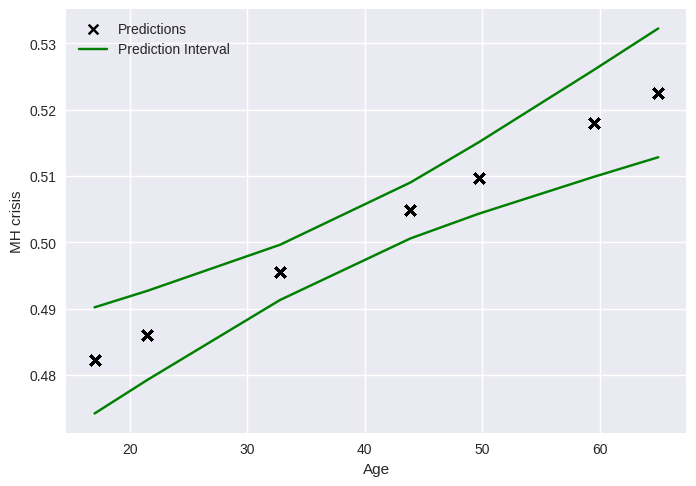

In [37]:
import numpy as np
import matplotlib.pyplot as plt

scdf = cdf.loc[~cdf['age'].isna(), :]
scdf = scdf.sort_values('age')
target = scdf['Actions_at_arrest___Mental_inst'].reset_index(drop=True)
ethnicity = pd.get_dummies(scdf['Perceived_Race']).reset_index(drop=True)
age = scdf['age'].reset_index(drop=True)
gender = pd.get_dummies(scdf['Sex']).reset_index(drop=True)
crime_type = pd.get_dummies(scdf['Occurrence_Category']).reset_index(drop=True)
combative_person = pd.get_dummies(scdf['Actions_at_arrest___Combative__'], prefix="Combative").reset_index(drop=True)

y = target.to_numpy()
x = age.to_numpy()
oversample = SMOTE(random_state=2)
x, y = oversample.fit_resample(x.reshape(-1, 1), y)

sorted_pairs = sorted(zip(x, y))
x, y = zip(*sorted_pairs)
X = sm.add_constant(x)

model = sm.Logit(y, X).fit()
proba = model.predict(X)

# estimate confidence interval for predicted probabilities
cov = model.cov_params()
gradient = (proba * (1 - proba) * X.T).T # matrix of gradients for each observation
std_errors = np.array([np.sqrt(np.dot(np.dot(g, cov), g)) for g in gradient])
c = 1.96 # multiplier for confidence interval
upper = np.maximum(0, np.minimum(1, proba + std_errors * c))
lower = np.maximum(0, np.minimum(1, proba - std_errors * c))

# plt.plot(x, proba)
plt.scatter(x, proba, label='Predictions', marker='x', color='black')
plt.plot(x, lower, color='g', label='Prediction Interval')
plt.plot(x, upper, color='g')
# plt.ylim([0.02, 0.1])
plt.xlabel('Age')
plt.ylabel('MH crisis')
plt.legend()
plt.show()

## Feature reduction to discover which predicting features increase the likelihood of being booked and then categorized as a MH crisis

### Iteration 1 - testing all 5 features (ethnicity, age, gender, crime type and combative person) by removing 1 feature per test.

In [38]:
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

target = cdf['Actions_at_arrest___Mental_inst'].reset_index(drop=True)
ethnicity = pd.get_dummies(cdf['Perceived_Race']).reset_index(drop=True)
age = cdf['age'].reset_index(drop=True)
gender = pd.get_dummies(cdf['Sex']).reset_index(drop=True)
crime_type = pd.get_dummies(cdf['Occurrence_Category']).reset_index(drop=True)
combative_person = pd.get_dummies(cdf['Actions_at_arrest___Combative__'], prefix="Combative").reset_index(drop=True)

data = pd.concat([target, ethnicity, age, gender, crime_type, combative_person], axis=1)
data = data.loc[~data['age'].isna(), :]
y = data['Actions_at_arrest___Mental_inst']
x = data.drop(['Actions_at_arrest___Mental_inst'], axis=1)

test1 = ['age'] + list(gender.columns) + list(crime_type.columns) + list(combative_person.columns)
test2 = list(ethnicity.columns) + list(gender.columns) + list(crime_type.columns) + list(combative_person.columns)
test3 = list(ethnicity.columns) + ['age'] + list(crime_type.columns) + list(combative_person.columns)
test4 = list(ethnicity.columns) + ['age'] + list(gender.columns) + list(combative_person.columns)
test5 = list(ethnicity.columns) + ['age'] + list(gender.columns) + list(crime_type.columns)

for i, test in enumerate([test1, test2, test3, test4, test5]):
  print('test ', i+1, ' : ', test)
  # Use SMOTE to oversample the minority data
  oversample = SMOTE(random_state=2)
  x_resampled, y_resampled = oversample.fit_resample(x[test], y)

  # x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)
  logit_model = sm.Logit(y_resampled, x_resampled)
  result = logit_model.fit()
  print(result.summary())

test  1  :  ['age', 'F', 'M', 'Assault', 'Assault & Other crimes against persons', 'Break & Enter', 'Break and Enter', 'Crimes against Children', 'Drug Related', 'FTA/FTC, Compliance Check & Parollee', 'FTA/FTC/Compliance Check/Parollee', 'Fraud', 'Harassment & Threatening', 'Harassment/Threatening', 'Homicide', 'Impaired', 'LLA', 'Mental Health', 'Mischief', 'Mischief & Fraud', 'Other Offence', 'Other Statute', 'Other Statute & Other Incident Type', 'Police Category - Administrative', 'Police Category - Incident', 'Robbery & Theft', 'Robbery/Theft', 'Sexual Related Crime', 'Sexual Related Crimes & Crimes Against Children', 'Vehicle Related', 'Vehicle Related (inc. Impaired)', 'Warrant', 'Weapons', 'Weapons & Homicide', 'Combative_0', 'Combative_1']
         Current function value: 0.550722
         Iterations: 35


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                  Logit Regression Results                                 
Dep. Variable:     Actions_at_arrest___Mental_inst   No. Observations:                68120
Model:                                       Logit   Df Residuals:                    68084
Method:                                        MLE   Df Model:                           35
Date:                             Fri, 14 Apr 2023   Pseudo R-squ.:                  0.2055
Time:                                     18:48:21   Log-Likelihood:                -37515.
converged:                                   False   LL-Null:                       -47217.
Covariance Type:                         nonrobust   LLR p-value:                     0.000
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
age                             

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                  Logit Regression Results                                 
Dep. Variable:     Actions_at_arrest___Mental_inst   No. Observations:                68120
Model:                                       Logit   Df Residuals:                    68077
Method:                                        MLE   Df Model:                           42
Date:                             Fri, 14 Apr 2023   Pseudo R-squ.:                  0.1621
Time:                                     18:48:28   Log-Likelihood:                -39563.
converged:                                   False   LL-Null:                       -47217.
Covariance Type:                         nonrobust   LLR p-value:                     0.000
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Black                           

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                  Logit Regression Results                                 
Dep. Variable:     Actions_at_arrest___Mental_inst   No. Observations:                68120
Model:                                       Logit   Df Residuals:                    68078
Method:                                        MLE   Df Model:                           41
Date:                             Fri, 14 Apr 2023   Pseudo R-squ.:                  0.2928
Time:                                     18:48:32   Log-Likelihood:                -33391.
converged:                                   False   LL-Null:                       -47217.
Covariance Type:                         nonrobust   LLR p-value:                     0.000
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Black                           

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



### Iteration 2 -- In teration 1, we discovered that test 3 was the best after removing 'Gender'. So we will continue feature reduction without gender.

In [39]:
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# test = list(ethnicity.columns) + ['age'] + list(crime_type.columns) + list(combative_person.columns)
test1 = ['age'] + list(crime_type.columns) + list(combative_person.columns)
test2 = list(ethnicity.columns) + list(crime_type.columns) + list(combative_person.columns)
test3 = list(ethnicity.columns) + ['age'] + list(combative_person.columns)
test4 = list(ethnicity.columns) + ['age'] + list(crime_type.columns)

for i, test in enumerate([test1, test2, test3, test4]):
  print('test ', i+1, ' : ', test)
  # Use SMOTE to oversample the minority data
  oversample = SMOTE(random_state=2)
  x_resampled, y_resampled = oversample.fit_resample(x[test], y)

  # x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)
  logit_model = sm.Logit(y_resampled, x_resampled)
  result = logit_model.fit()
  print(result.summary())

test  1  :  ['age', 'Assault', 'Assault & Other crimes against persons', 'Break & Enter', 'Break and Enter', 'Crimes against Children', 'Drug Related', 'FTA/FTC, Compliance Check & Parollee', 'FTA/FTC/Compliance Check/Parollee', 'Fraud', 'Harassment & Threatening', 'Harassment/Threatening', 'Homicide', 'Impaired', 'LLA', 'Mental Health', 'Mischief', 'Mischief & Fraud', 'Other Offence', 'Other Statute', 'Other Statute & Other Incident Type', 'Police Category - Administrative', 'Police Category - Incident', 'Robbery & Theft', 'Robbery/Theft', 'Sexual Related Crime', 'Sexual Related Crimes & Crimes Against Children', 'Vehicle Related', 'Vehicle Related (inc. Impaired)', 'Warrant', 'Weapons', 'Weapons & Homicide', 'Combative_0', 'Combative_1']
         Current function value: 0.566809
         Iterations: 35
                                  Logit Regression Results                                 
Dep. Variable:     Actions_at_arrest___Mental_inst   No. Observations:                68120


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



         Current function value: 0.587648
         Iterations: 35
                                  Logit Regression Results                                 
Dep. Variable:     Actions_at_arrest___Mental_inst   No. Observations:                68120
Model:                                       Logit   Df Residuals:                    68079
Method:                                        MLE   Df Model:                           40
Date:                             Fri, 14 Apr 2023   Pseudo R-squ.:                  0.1522
Time:                                     18:48:41   Log-Likelihood:                -40031.
converged:                                   False   LL-Null:                       -47217.
Covariance Type:                         nonrobust   LLR p-value:                     0.000
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Optimization terminated successfully.
         Current function value: 0.615718
         Iterations 6
                                  Logit Regression Results                                 
Dep. Variable:     Actions_at_arrest___Mental_inst   No. Observations:                68120
Model:                                       Logit   Df Residuals:                    68109
Method:                                        MLE   Df Model:                           10
Date:                             Fri, 14 Apr 2023   Pseudo R-squ.:                  0.1117
Time:                                     18:48:41   Log-Likelihood:                -41943.
converged:                                    True   LL-Null:                       -47217.
Covariance Type:                         nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



### Iteration 3 -- In iteration 2, we discovered that test 1 was the best after removing ethnicity -- so we proceed without it.

In [40]:
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# test = ['age'] + list(crime_type.columns) + list(combative_person.columns)
test1 = list(crime_type.columns) + list(combative_person.columns)
test2 = ['age'] + list(combative_person.columns)
test3 = ['age'] + list(crime_type.columns)

for i, test in enumerate([test1, test2, test3]):
  print('test ', i+1, ' : ', test)
  # Use SMOTE to oversample the minority data
  oversample = SMOTE(random_state=3)
  x_resampled, y_resampled = oversample.fit_resample(x[test], y)

  # x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)
  logit_model = sm.Logit(y_resampled, x_resampled)
  result = logit_model.fit()
  print(result.summary())

test  1  :  ['Assault', 'Assault & Other crimes against persons', 'Break & Enter', 'Break and Enter', 'Crimes against Children', 'Drug Related', 'FTA/FTC, Compliance Check & Parollee', 'FTA/FTC/Compliance Check/Parollee', 'Fraud', 'Harassment & Threatening', 'Harassment/Threatening', 'Homicide', 'Impaired', 'LLA', 'Mental Health', 'Mischief', 'Mischief & Fraud', 'Other Offence', 'Other Statute', 'Other Statute & Other Incident Type', 'Police Category - Administrative', 'Police Category - Incident', 'Robbery & Theft', 'Robbery/Theft', 'Sexual Related Crime', 'Sexual Related Crimes & Crimes Against Children', 'Vehicle Related', 'Vehicle Related (inc. Impaired)', 'Warrant', 'Weapons', 'Weapons & Homicide', 'Combative_0', 'Combative_1']
         Current function value: 0.590158
         Iterations: 35
                                  Logit Regression Results                                 
Dep. Variable:     Actions_at_arrest___Mental_inst   No. Observations:                68120
Model: 

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Optimization terminated successfully.
         Current function value: 0.623353
         Iterations 6
                                  Logit Regression Results                                 
Dep. Variable:     Actions_at_arrest___Mental_inst   No. Observations:                68120
Model:                                       Logit   Df Residuals:                    68117
Method:                                        MLE   Df Model:                            2
Date:                             Fri, 14 Apr 2023   Pseudo R-squ.:                  0.1007
Time:                                     18:48:45   Log-Likelihood:                -42463.
converged:                                    True   LL-Null:                       -47217.
Covariance Type:                         nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ag

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



### Iteration 4 -- in iteration 3, test 1 had the best results after removing age. Proceeding with it.

In [41]:
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# test = list(crime_type.columns) + list(combative_person.columns)
test1 = list(combative_person.columns)


for i, test in enumerate([test1]):
  print('test ', i+1, ' : ', test)
  # Use SMOTE to oversample the minority data
  oversample = SMOTE(random_state=3)
  x_resampled, y_resampled = oversample.fit_resample(x[test], y)

  # x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)
  logit_model = sm.Logit(y_resampled, x_resampled)
  result = logit_model.fit()
  print(result.summary())

test  1  :  ['Combative_0', 'Combative_1']
Optimization terminated successfully.
         Current function value: 0.622852
         Iterations 6
                                  Logit Regression Results                                 
Dep. Variable:     Actions_at_arrest___Mental_inst   No. Observations:                68120
Model:                                       Logit   Df Residuals:                    68118
Method:                                        MLE   Df Model:                            1
Date:                             Fri, 14 Apr 2023   Pseudo R-squ.:                  0.1014
Time:                                     18:48:47   Log-Likelihood:                -42429.
converged:                                    True   LL-Null:                       -47217.
Covariance Type:                         nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

### Test 1 yielded the best results -- Strongest predictor seems to be 'Combative Individual'

#odds for Combative 0 and 1 -- there is a 7.04 increase for MH Crisis if alleged perpetrator are Combative at Arrest. 

In [42]:
np.exp(result.params)

Combative_0    0.709890
Combative_1    7.035851
dtype: float64

LR Model with Confusion Matrix and F1 score based off combative Feature only

In [43]:

from sklearn.metrics import classification_report

oversample = SMOTE(random_state=3)
x_resampled, y_resampled = oversample.fit_resample(x[test], y)
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=3)
logit_model = sm.Logit(y_train, x_train)
result = logit_model.fit()
print(result.summary())

# Generate a classification report 
y_pred = result.predict(x_test)
y_pred_class = (y_pred > 0.5).astype(int) # Convert predicted probabilities
print(classification_report(y_test, y_pred_class))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_class).ravel()
print("Confusion Matrix:")
print("------------------")
print(f"True Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")
print(f"True Positive: {tp}")


Optimization terminated successfully.
         Current function value: 0.623115
         Iterations 6
                                  Logit Regression Results                                 
Dep. Variable:     Actions_at_arrest___Mental_inst   No. Observations:                54496
Model:                                       Logit   Df Residuals:                    54494
Method:                                        MLE   Df Model:                            1
Date:                             Fri, 14 Apr 2023   Pseudo R-squ.:                  0.1010
Time:                                     18:48:47   Log-Likelihood:                -33957.
converged:                                    True   LL-Null:                       -37774.
Covariance Type:                         nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Co